In [1]:
import sys
import os

# Add the grand-parent directory to the Python path
parent_dir = os.path.abspath('../..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import modules
import ddsp_textures.signal_processors.synthesizers
import ddsp_textures.auxiliar.seeds

# Import extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch

# Resysnthesis function
def resynthesize_and_display(segments, sr, seed, N_filter_bank, frame_size, param_per_env, label, N):
    for _ in range(N):
        # segment = segments[np.random.randint(len(segments))]
        segment = segments[10*_]
        segment = torch.tensor(segment, dtype=torch.float32)
        param_real, param_imag = ddsp_textures.signal_processors.synthesizers.SubEnv_param_extractor(segment, sr, N_filter_bank, param_per_env)
        new_audio              = ddsp_textures.signal_processors.synthesizers.SubEnv(param_real, param_imag, seed)
        print(f"{label} original audio")
        display(Audio(data=segment.numpy(), rate=sr))
        print(f"{label} resynthesized audio")
        display(Audio(data=new_audio.numpy(), rate=sr))

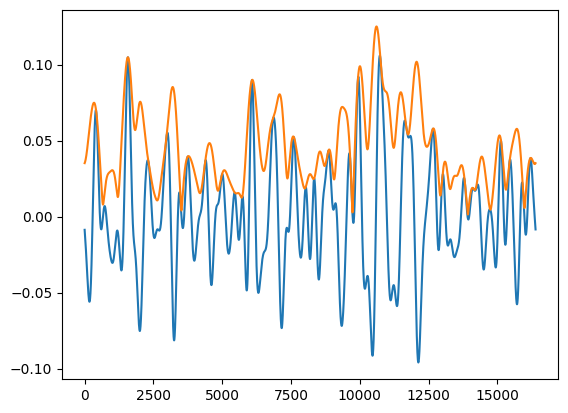

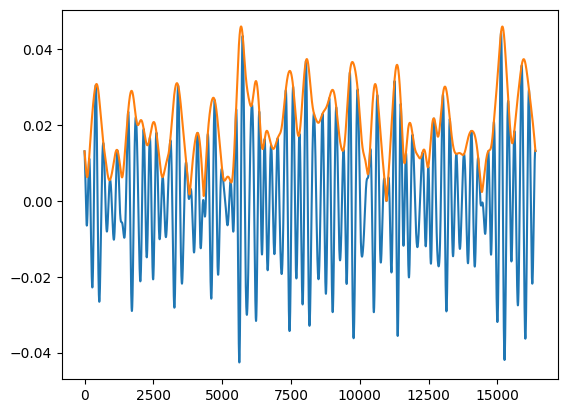

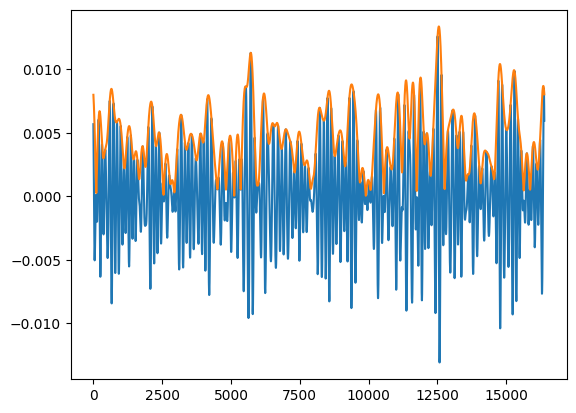

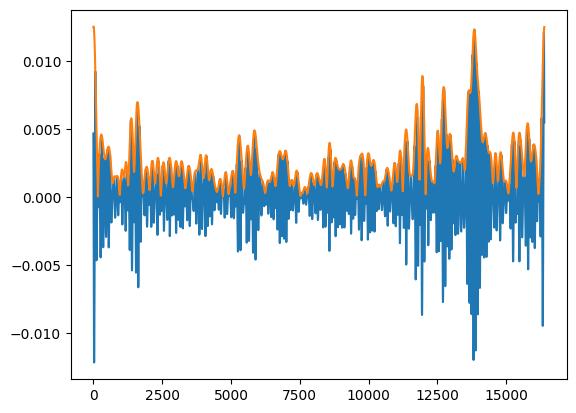

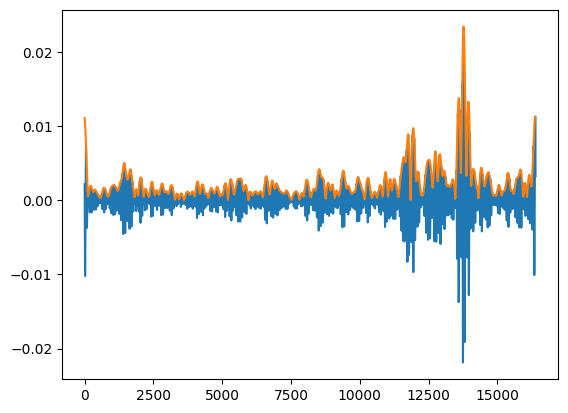

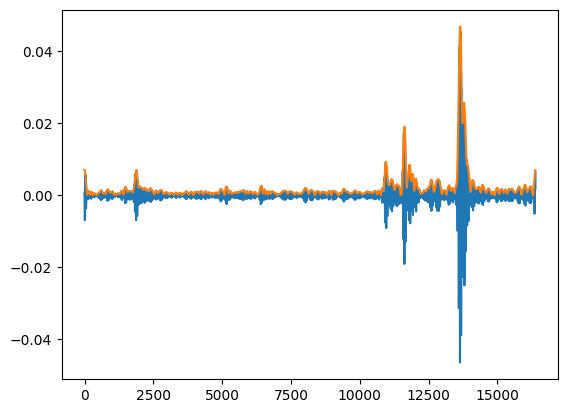

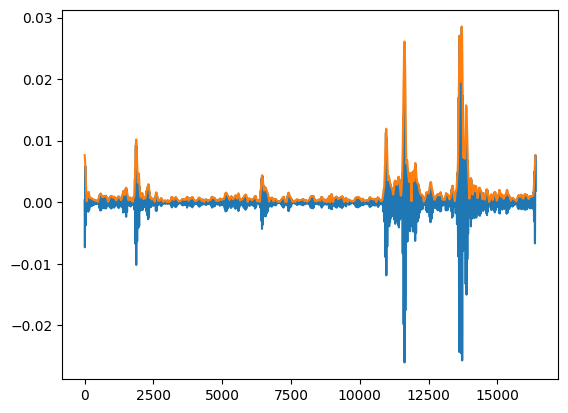

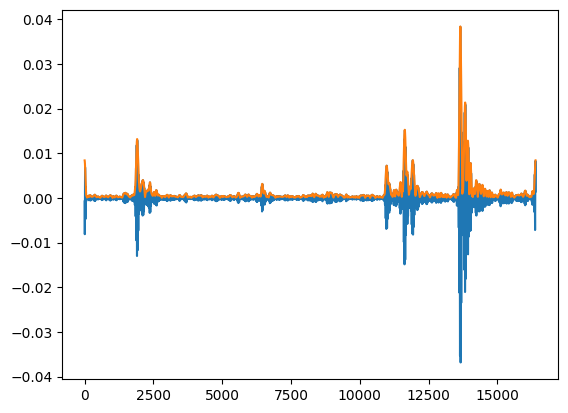

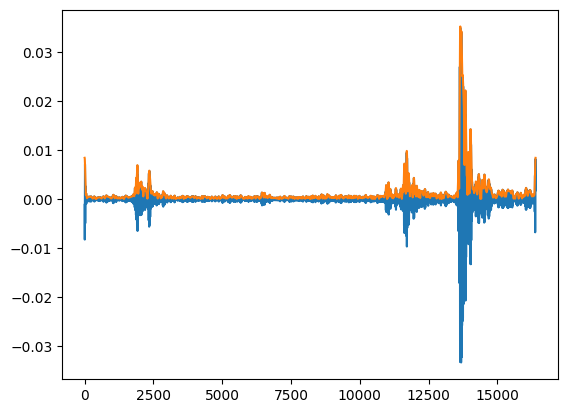

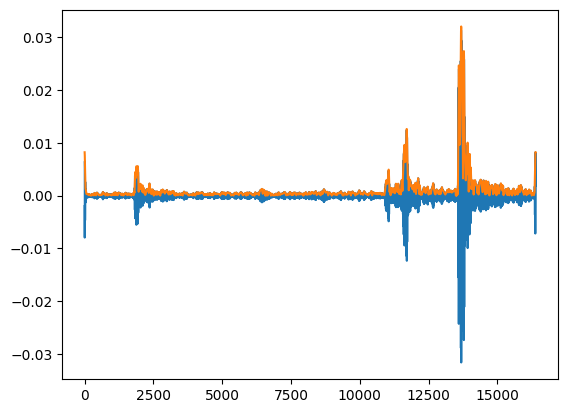

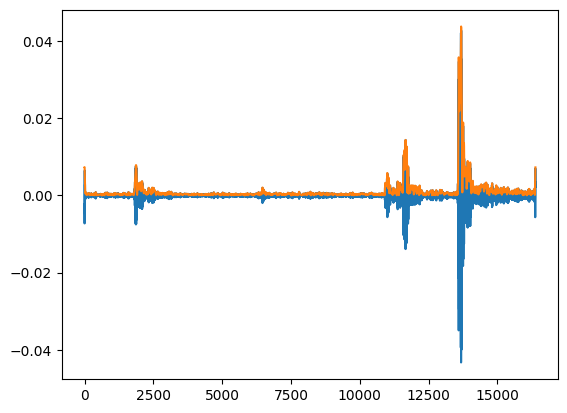

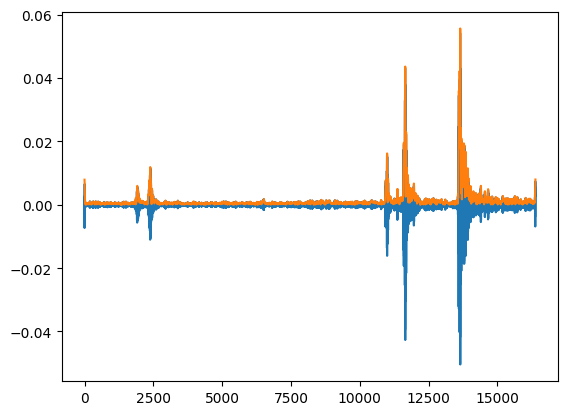

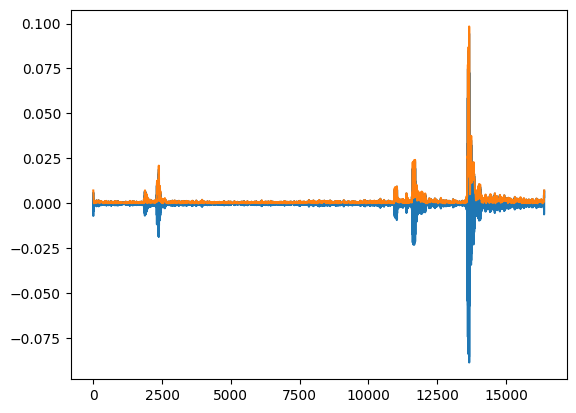

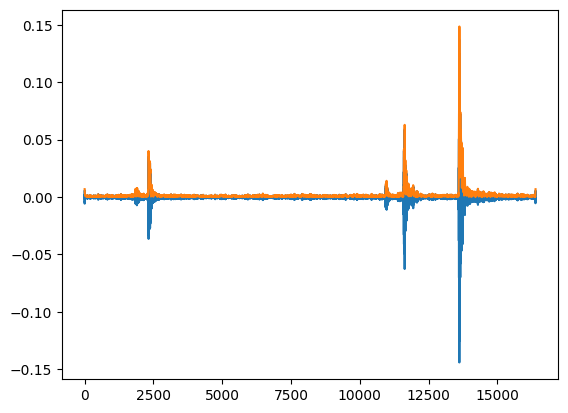

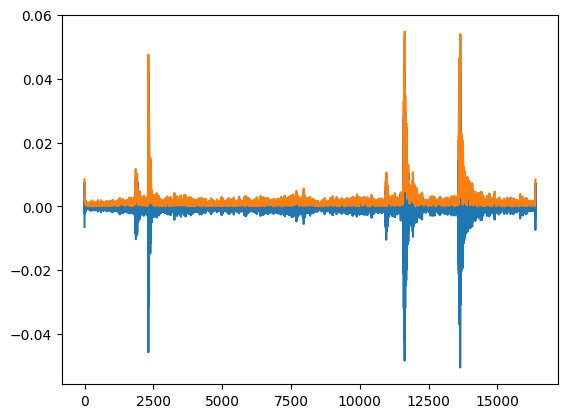

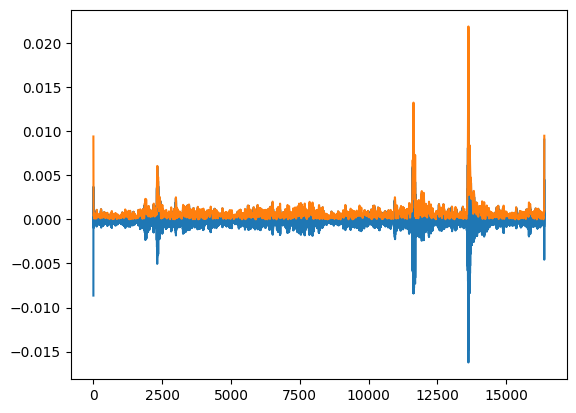

In [2]:
from   ddsp_textures.auxiliar.seeds import *

def env_computer(signal, fs, N_filter_bank, param_per_env):
    # send error if param_per_env is not even
    if param_per_env % 2 != 0:
        raise ValueError("param_per_env must be an even number (cause these are complex numbers).")
    low_lim, high_lim = 20, fs / 2  # Low limit of filter
    size = signal.size(0)
    
    # Assuming fb.EqualRectangularBandwidth works with torch tensors
    erb_bank = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(size, fs, N_filter_bank, low_lim, high_lim)
    subbands = erb_bank.generate_subbands(signal)  # generate subbands for signal y
    
    erb_subbands = subbands[1:-1, :].clone().to(dtype=torch.float32).detach()
    erb_envs = torch.abs(hilbert(erb_subbands))

    for i in range(N_filter_bank):
        #plot both erb_subbands and erb_envs
        plt.figure()
        plt.plot(erb_subbands[i, :].numpy())
        plt.plot(erb_envs[i, :].numpy())
        plt.show()

fire_path = "../sounds/fire_sounds/fire.wav"
sr = 44100
fire_audio, _ = librosa.load(fire_path, sr=sr)
#random integer from 0 to sample size
lorea = np.random.randint(0, len(fire_audio)- 2**14)
fire_audio = fire_audio[lorea : lorea+2**14]
# Compute the envelope of the audio
N_filter_bank = 16
param_per_env = 256
segment = torch.tensor(fire_audio, dtype=torch.float32)
env_computer(segment, sr, N_filter_bank, param_per_env)

In [7]:
# FIRE RESYNTHESIS --------------------------------------

# Load audio to resynthesize ----------------------------
fire_path = "../sounds/fire_sounds/fire.wav"
sr = 44100
fire_audio, _ = librosa.load(fire_path, sr=sr)

# Make list of segments for fire and water --------------
frame_size = 2**16 # 2**16 = 65536 correspond to around 1.5 seconds (quite long frames)
hop_size = 2**16
fire_segments = []

for i in range(0, len(fire_audio) - frame_size, hop_size):
    fire_segments.append(fire_audio[i:i + frame_size])

# Seed creation -----------------------------------------
N_filter_bank = 16 # This is a high number of filter (16 is the typical)
seed = ddsp_textures.auxiliar.seeds.seed_maker(frame_size, 44100, N_filter_bank)

# Run the resynthesizer for a bunch of fire and water segments
param_per_env = 512  # 1024*24 = 2**13 * 3 => compression of (2**13 * 3)/2**16 = 3/8 ~ 0.375 
resynthesize_and_display(fire_segments,  sr, seed, N_filter_bank, frame_size, param_per_env, "Fire",  5)

NUMBER OF PARAMETERS:  8192
Fire original audio


Fire resynthesized audio


NUMBER OF PARAMETERS:  8192
Fire original audio


Fire resynthesized audio


NUMBER OF PARAMETERS:  8192
Fire original audio


Fire resynthesized audio


NUMBER OF PARAMETERS:  8192
Fire original audio


Fire resynthesized audio


NUMBER OF PARAMETERS:  8192
Fire original audio


Fire resynthesized audio


In [4]:
# WATER RESYNTHESIS --------------------------------------

# Load audio to resynthesize ----------------------------
water_path = "../sounds/water_sounds/water.wav"
sr = 44100
water_audio, _ = librosa.load(water_path, sr=sr)

# Water segments ----------------------------------------
frame_size = 2**16 # 2**14 corresponds to around 0.37 seconds (sort of short frames)
hop_size   = 2**16
water_segments = []

for i in range(0, len(water_audio) - frame_size, hop_size):
    water_segments.append(water_audio[i:i + frame_size])

# Seed creation -----------------------------------------
N_filter_bank = 32
seed = ddsp_textures.auxiliar.seeds.seed_maker(frame_size, 44100, N_filter_bank)

# Run the resynthesizer for a bunch of fire and water segments
param_per_env = 2048  # 256*16 = 2**12 => compression of 2**12/2**14 = 1/4
resynthesize_and_display(water_segments,  sr, seed, N_filter_bank, frame_size, param_per_env, "Water",  3)

NUMBER OF PARAMETERS:  65536
Water original audio


Water resynthesized audio


NUMBER OF PARAMETERS:  65536
Water original audio


Water resynthesized audio


NUMBER OF PARAMETERS:  65536
Water original audio


Water resynthesized audio


In [5]:
# New resynthesis function using the stems functions
def resynthesize_and_display_stems(segments, sr, seed, N_filter_bank, frame_size, param_per_env, label, N):
    for _ in range(N):
        # Select a random audio segment from the provided list
        segment = segments[np.random.randint(len(segments))]
        segment = torch.tensor(segment, dtype=torch.float32)

        # Extract parameters (real and imaginary parts) for the envelope synthesis
        param_real, param_imag = ddsp_textures.signal_processors.synthesizers.SubEnv_param_extractor(
            segment, sr, N_filter_bank, param_per_env)

        # Get the list of env_locals using the modified SubEnv function (stems)
        env_locals = ddsp_textures.signal_processors.synthesizers.SubEnv_stems(param_real, param_imag, frame_size, N_filter_bank)

        # Convert the env_locals back into a signal using env_locals_to_signal
        new_audio = ddsp_textures.signal_processors.synthesizers.SubEnv_stems_to_signal(env_locals, seed)

        # Display original and resynthesized audio
        print(f"{label} original audio")
        display(Audio(data=segment.numpy(), rate=sr))

        print(f"{label} resynthesized audio from stems")
        display(Audio(data=new_audio.numpy(), rate=sr))

        new_audio_2 = ddsp_textures.signal_processors.synthesizers.SubEnv(param_real, param_imag, seed)

        print(f"{label} resynthesized audio from original function")
        display(Audio(data=new_audio_2.numpy(), rate=sr))

In [6]:
# WATER RESYNTHESIS --------------------------------------

# Load audio to resynthesize ----------------------------
water_path = "../sounds/water_sounds/water_short.wav"
sr = 44100
water_audio, _ = librosa.load(water_path, sr=sr)

# Water segments ----------------------------------------
frame_size = 2**16 # 2**14 corresponds to around 0.37 seconds (sort of short frames)
hop_size = 2**16
water_segments = []

for i in range(0, len(water_audio) - frame_size, hop_size):
    water_segments.append(water_audio[i:i + frame_size])

# Seed creation -----------------------------------------
N_filter_bank = 32
seed = ddsp_textures.auxiliar.seeds.seed_maker(frame_size, 44100, N_filter_bank)

# Run the resynthesizer for a bunch of fire and water segments
param_per_env = 512  # 256*16 = 2**12 => compression of 2**12/2**14 = 1/4
resynthesize_and_display_stems(water_segments,  sr, seed, N_filter_bank, frame_size, param_per_env, "Water",  3)

/tmp/ipykernel_590413/1192100251.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  water_audio, _ = librosa.load(water_path, sr=sr)
/home/esteban/projects/ddsp_textures/env_ddsp_textures/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '../sounds/water_sounds/water_short.wav'

param_real shape: torch.Size([2048])
param_imag shape: torch.Size([2048])
env_locals length: 16
env_locals[0] shape: torch.Size([16384])


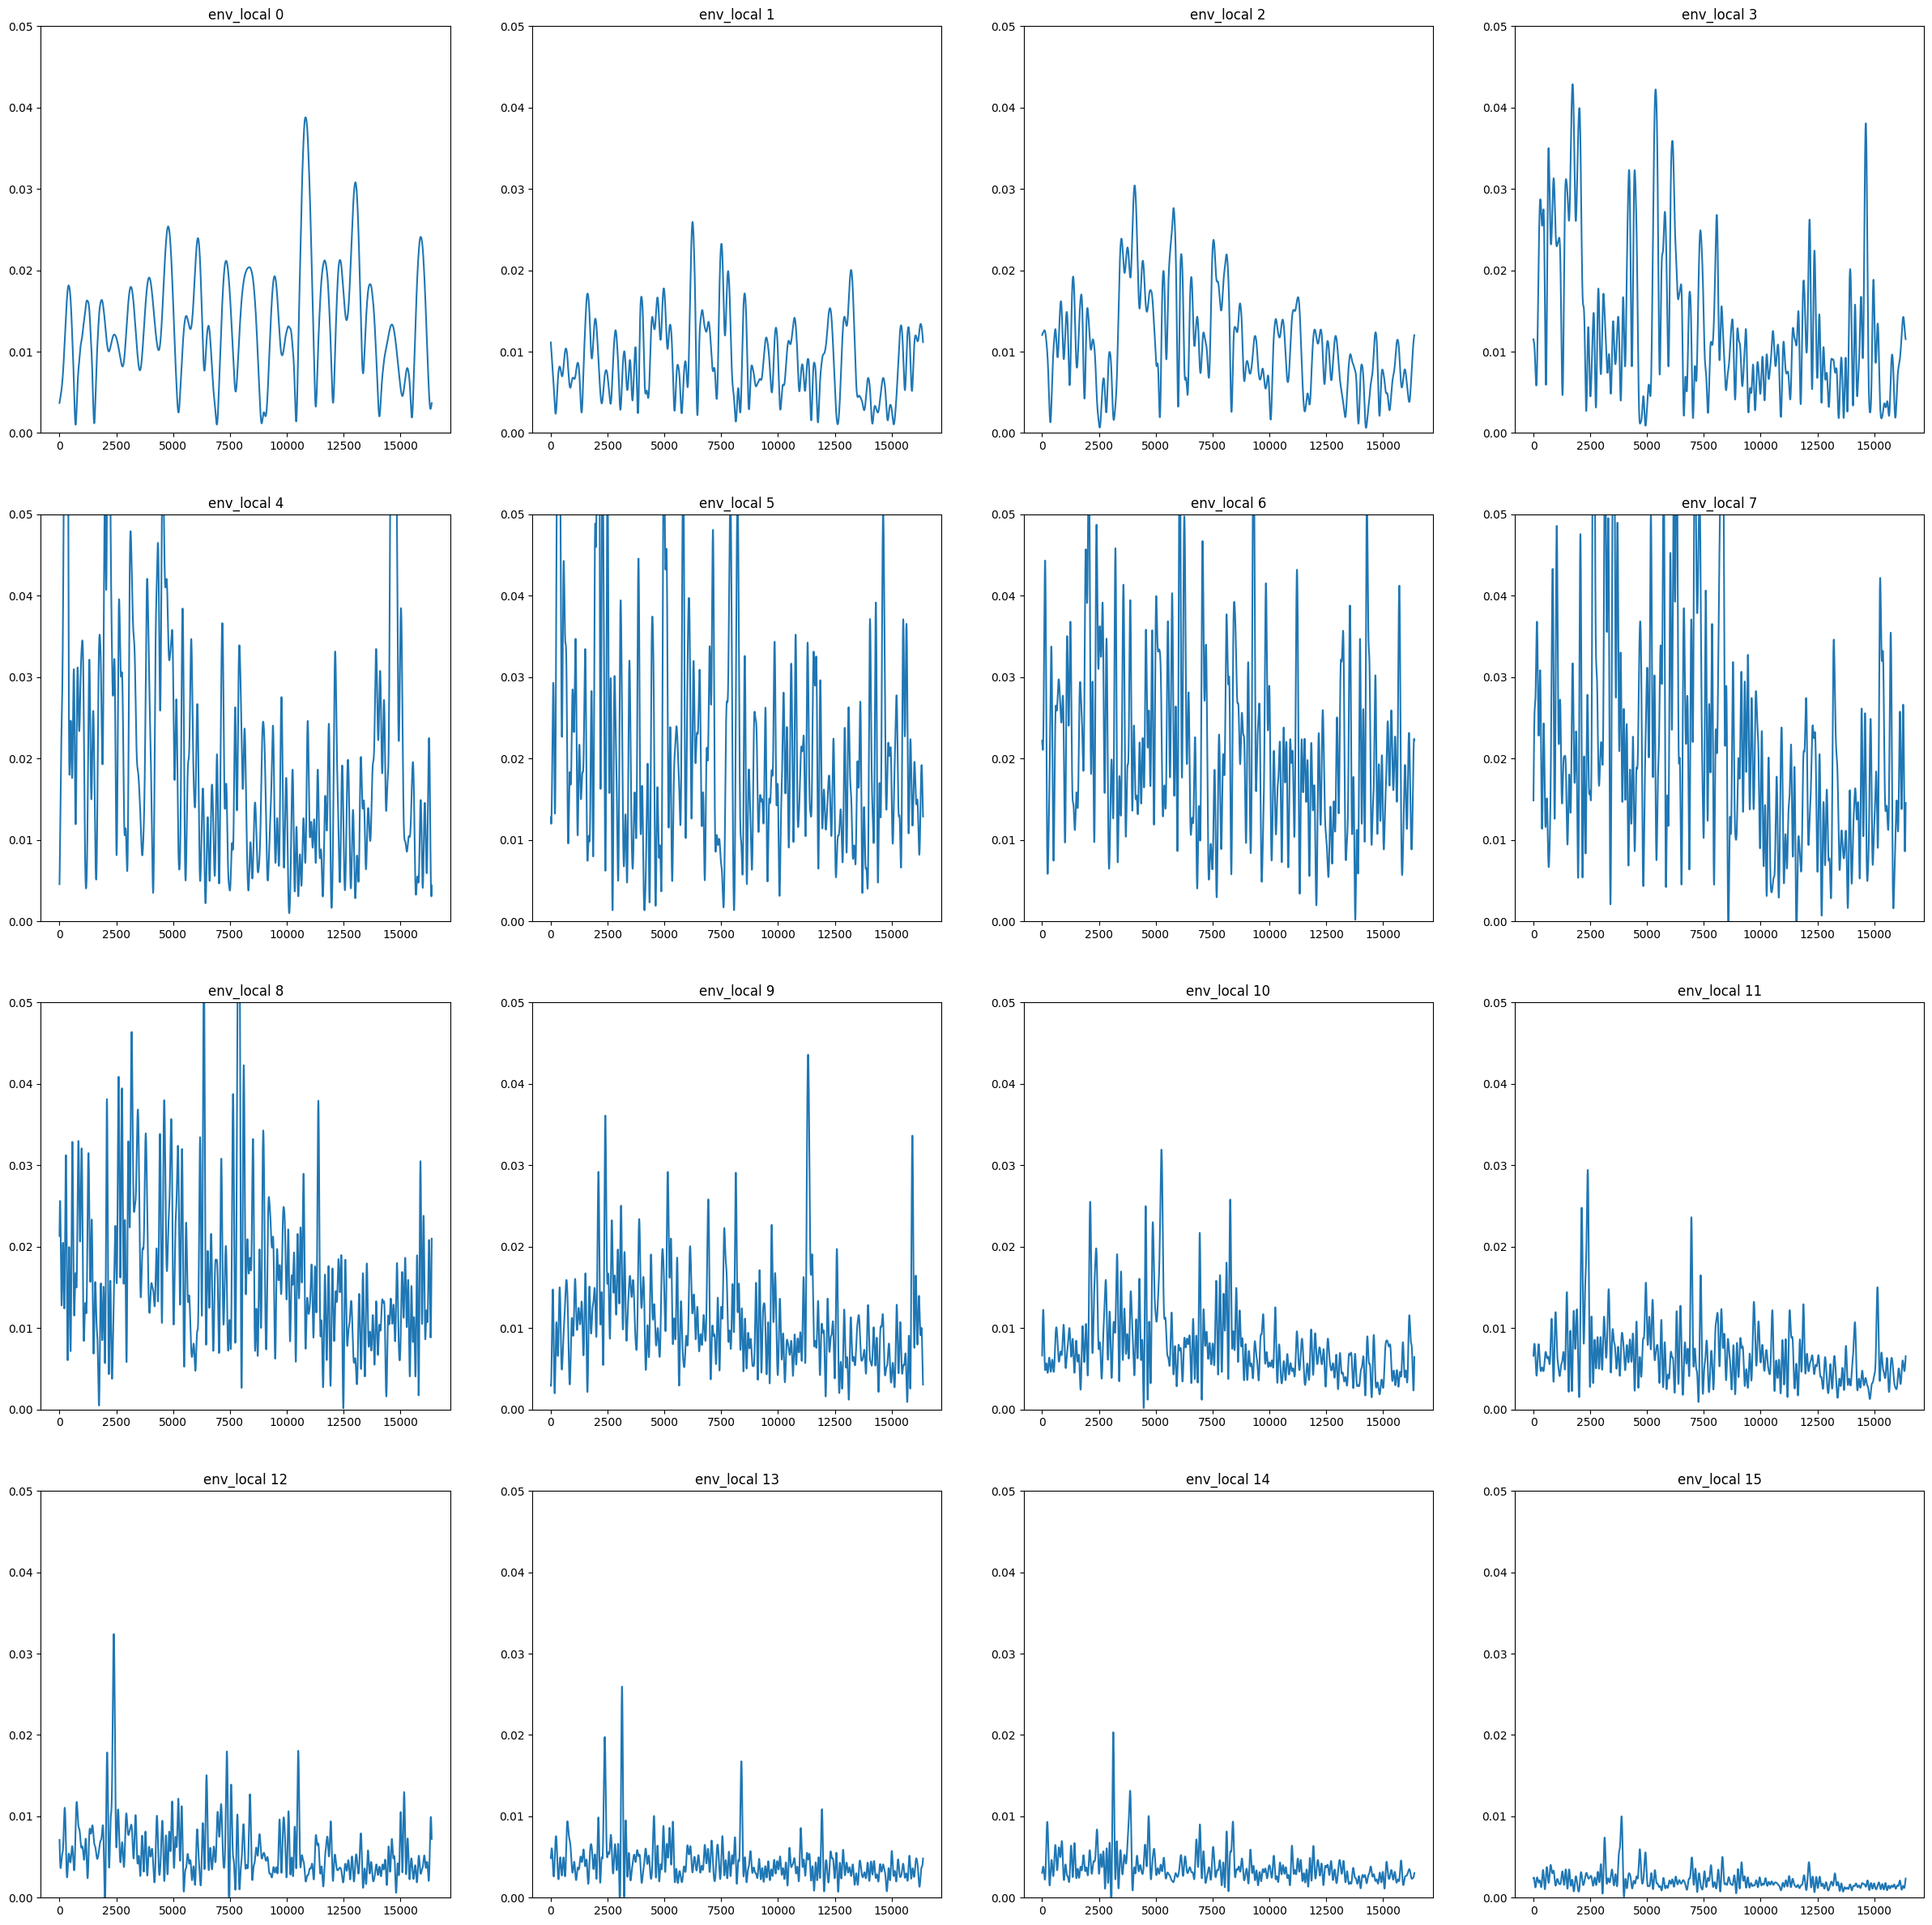

In [ ]:
# Dimensions check for stems functions -------------------

# Load audio to resynthesize ----------------------------
water_path = "../sounds/water_sounds/water_short.wav"
sr = 44100
water_audio, _ = librosa.load(water_path, sr=sr)

# Water segments ----------------------------------------
frame_size = 2**14 # 2**14 corresponds to around 0.37 seconds (sort of short frames)
hop_size = 2**14
water_segment = water_audio[10*frame_size:11*frame_size]
water_segment_torch = torch.tensor(water_segment, dtype=torch.float32)
# Seed creation -----------------------------------------
N_filter_bank = 16
seed = ddsp_textures.auxiliar.seeds.seed_maker(frame_size, 44100, N_filter_bank)

# Run the resynthesizer for a bunch of fire and water segments
param_per_env = 256  # 256*16 = 2**12 => compression of 2**12/2**14 = 1/4

# Extract parameters (real and imaginary parts) for the envelope synthesis
param_real, param_imag = ddsp_textures.signal_processors.synthesizers.SubEnv_param_extractor(water_segment_torch, sr, N_filter_bank, param_per_env)

# print shapes
print("param_real shape:", param_real.shape)
print("param_imag shape:", param_imag.shape)

env_locals = ddsp_textures.signal_processors.synthesizers.SubEnv_stems(param_real, param_imag, frame_size, N_filter_bank)

print("env_locals length:", len(env_locals))
print("env_locals[0] shape:", env_locals[0].shape)

# plot all env_locals in one figure of 4x6 subplots with the same y-axis
plt.figure(figsize=(30, 30))
for i in range(len(env_locals)):
    plt.subplot(4, 4, i+1)
    plt.ylim(0, 0.05)
    plt.plot(env_locals[i])
    plt.title(f"env_local {i}")
plt.show()

In [ ]:
# Dimensions check for stems functions -------------------

# Load audio to resynthesize ----------------------------
water_path = "../sounds/water_sounds/water_short.wav"
sr = 44100
water_audio, _ = librosa.load(water_path, sr=sr)

# Water segments ----------------------------------------
frame_size = 2**14 # 2**14 corresponds to around 0.37 seconds (sort of short frames)
hop_size = 2**14
water_segments = []

# make batch of L segments
L = 16
for i in range(0, L):
    segment_local = water_audio[i*hop_size:i*hop_size + frame_size]
    segment_local_torch = torch.tensor(segment_local, dtype=torch.float32)
    water_segments.append(segment_local_torch)

#water segments to batch
water_segment_torch = torch.stack(water_segments)
print("(batch) water_segment_torch shape:", water_segment_torch.shape)

# Seed creation -----------------------------------------
N_filter_bank = 24
seed = ddsp_textures.auxiliar.seeds.seed_maker(frame_size, 44100, N_filter_bank)

# Run the resynthesizer for a bunch of fire and water segments
param_per_env = 512  # 256*16 = 2**12 => compression of 2**12/2**14 = 1/4

# Extract parameters (real and imaginary parts) for each segment in the batch and make a new batch of parameters
param_real = []
param_imag = []
for i in range(0, L):
    segment_local = water_segment_torch[i]
    param_real_local, param_imag_local = ddsp_textures.signal_processors.synthesizers.SubEnv_param_extractor(segment_local, sr, N_filter_bank, param_per_env)
    param_real.append(param_real_local)
    param_imag.append(param_imag_local)

#Make batches of parameters
param_real = torch.stack(param_real)
param_imag = torch.stack(param_imag)

# print shapes
print("(batch) param_real shape:", param_real.shape)
print("(batch) param_imag shape:", param_imag.shape)

env_locals_batches = ddsp_textures.signal_processors.synthesizers.SubEnv_stems_batches(param_real, param_imag, frame_size, N_filter_bank)

#print shape
print("env_locals_batches shape:", env_locals_batches.shape)

(batch) water_segment_torch shape: torch.Size([16, 16384])
(batch) param_real shape: torch.Size([16, 6144])
(batch) param_imag shape: torch.Size([16, 6144])
env_locals_batches shape: torch.Size([16, 24, 16384])


In [ ]:
results_batches = ddsp_textures.signal_processors.synthesizers.SubEnv_stems_to_signals_batches(env_locals_batches, seed, target_loudness=1)
print("results_batches shape:", results_batches.shape)

# play each sound in the batch together with its original version
for i in range(0, L):
    print(f"original audio {i}")
    display(Audio(data=water_segment_torch[i].numpy(), rate=sr))
    print(f"resynthesized audio {i}")
    display(Audio(data=results_batches[i].numpy(), rate=sr))

results_batches shape: torch.Size([16, 16384])
original audio 0


resynthesized audio 0


original audio 1


resynthesized audio 1


original audio 2


resynthesized audio 2


original audio 3


resynthesized audio 3


original audio 4


resynthesized audio 4


original audio 5


resynthesized audio 5


original audio 6


resynthesized audio 6


original audio 7


resynthesized audio 7


original audio 8


resynthesized audio 8


original audio 9


resynthesized audio 9


original audio 10


resynthesized audio 10


original audio 11


resynthesized audio 11


original audio 12


resynthesized audio 12


original audio 13


resynthesized audio 13


original audio 14


resynthesized audio 14


original audio 15


resynthesized audio 15
